# 1. 사용자 정의 손실함수
- 함수 정의 후 모델 컴파일시 적용 가능

In [3]:
import tensorflow as tf
import numpy as np
# 샘플 데이터 생성
X = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], dtype=float)
y = np.array([2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0], dtype=float)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[1])
])

# 사용자 정의 손실함수(Huber loss 구현)
def custom_huber_loss(y_true, y_pred):
    # 임계값 정의
    threshold = 1
    # 손실 계산
    error = y_true - y_pred

    small = tf.abs(error) <= threshold

    # l2 loss 적용
    small_error = tf.square(error) / 2

    # l1 loss 적용
    big_error = threshold * (tf.abs(error) - (threshold/2))

    # return
    return tf.where(small, small_error, big_error)

# 사용자 정의 custom_huber_loss 함수 적용
model.compile(optimizer='sgd', loss=custom_huber_loss)
model.fit(X, y, epochs=1000, verbose=0)

# 결과 확인
print(model.predict([7.0]))

[[16.037128]]


- 파이썬 내장함수나 넘파이 함수를 사용하지 않고 텐서플로 계산 함수를 적용해야 함

# 2. 사용자 정의 레이어


In [2]:
from tensorflow.keras.layers import Layer

class MyDense(Layer):
    def __init__(self, units=32, input_shape=None):
        super(MyDense, self).__init__(input_shape=input_shape)
        self.units = units
    
    def build(self, input_shape):
        # weight 초기화
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name='weight',
                             initial_value=w_init(shape=(input_shape[-1], self.units), dtype='float32'),
                             trainable=True)
        
        # bias 초기화
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name='bias', 
                             initial_value=b_init(shape=(self.units,), dtype='float32'),
                             trainable=True)
        
    def call(self, inputs):
        # wx + b
        return tf.matmul(inputs, self.w) + self.b

In [4]:
# 샘플 데이터 생성
X = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], dtype=float)
y = np.array([2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0], dtype=float)

# 사용자 정의 MyDense 레이어를 적용한 경우
model = tf.keras.Sequential([
    MyDense(units=1, input_shape=[1])
])

# 컴파일
model.compile(optimizer='sgd', loss='mse')

# 훈련
model.fit(X, y, epochs=1000, verbose=0)

# 결과 학인
print(model.predict([7.0]))

[[16.002666]]


# 3. 사용자 정의 훈련
## 3-1. train_on_batch
- `train_on_batch`를 활용하면 배치별로 구분해서 훈련 진행 가능

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Sequential

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

In [11]:
model = model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [12]:
# 배치 생성 함수
def get_batches(x, y, batch_size=32):
    for i in range(int(x.shape[0] // batch_size)):
        x_batch = x[i * batch_size:(i + 1) * batch_size]
        y_batch =y[i * batch_size:(i + 1) * batch_size]
        yield(np.asarray(x_batch), np.asarray(y_batch))

- 반복문 내부에서는 x, y의 쌍으로 묶인 1개의 배치를 생성 후 반환
- `yield`키워드는 for 루프가 실행될 때 yield 키워드 전까지 실행하고 해당 루프 결과를 반환, 다음 함수를 호출할 때 다음 루프가 실행되어 결과 반환

In [13]:
# 1개의 배치 로드
x, y = next(get_batches(x_train, y_train))
x.shape, y.shape

((32, 28, 28), (32,))

- `yield`로 반환하는 함수는 파이썬 제너레이터(generator) -> `next` 키워드 사용하여 값 반환
- `batch_size = 32`로 지정했기 때문에 32개의 x, y데이터가 튜플 형태의 쌍으로 반환

epoch:1, batch:50, batch_loss:0.0148, batch_accuracy:1.0000, avg_loss:0.0554
epoch:1, batch:100, batch_loss:0.0848, batch_accuracy:0.9609, avg_loss:0.0603
epoch:1, batch:150, batch_loss:0.1224, batch_accuracy:0.9766, avg_loss:0.0586
epoch:1, batch:200, batch_loss:0.1134, batch_accuracy:0.9688, avg_loss:0.0566
epoch:1, batch:250, batch_loss:0.0291, batch_accuracy:1.0000, avg_loss:0.0571
epoch:1, batch:300, batch_loss:0.1040, batch_accuracy:0.9766, avg_loss:0.0569
epoch:1, batch:350, batch_loss:0.0169, batch_accuracy:1.0000, avg_loss:0.0570
epoch:1, batch:400, batch_loss:0.0154, batch_accuracy:1.0000, avg_loss:0.0571
epoch:1, batch:450, batch_loss:0.0370, batch_accuracy:0.9844, avg_loss:0.0557


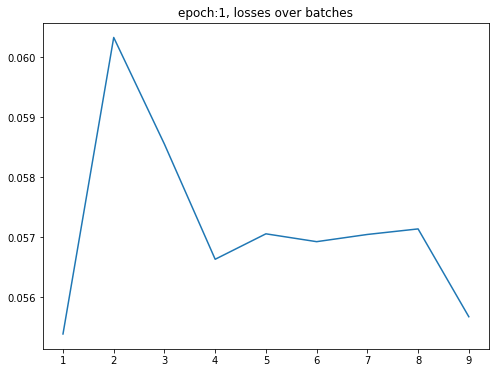

313/313 [==============================] - 1s 2ms/step - loss: 0.0930 - acc: 0.9699
------------------------------
epoch:1, val_loss:0.0930, val_acc:0.9699

epoch:2, batch:50, batch_loss:0.0106, batch_accuracy:1.0000, avg_loss:0.0419
epoch:2, batch:100, batch_loss:0.0518, batch_accuracy:0.9844, avg_loss:0.0440
epoch:2, batch:150, batch_loss:0.0823, batch_accuracy:0.9688, avg_loss:0.0426
epoch:2, batch:200, batch_loss:0.0887, batch_accuracy:0.9766, avg_loss:0.0416
epoch:2, batch:250, batch_loss:0.0228, batch_accuracy:0.9844, avg_loss:0.0418
epoch:2, batch:300, batch_loss:0.0952, batch_accuracy:0.9609, avg_loss:0.0418
epoch:2, batch:350, batch_loss:0.0118, batch_accuracy:1.0000, avg_loss:0.0420
epoch:2, batch:400, batch_loss:0.0085, batch_accuracy:1.0000, avg_loss:0.0421
epoch:2, batch:450, batch_loss:0.0135, batch_accuracy:1.0000, avg_loss:0.0409


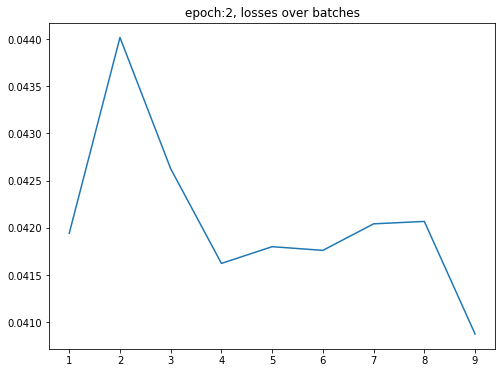

313/313 [==============================] - 1s 2ms/step - loss: 0.0825 - acc: 0.9740
------------------------------
epoch:2, val_loss:0.0825, val_acc:0.9740

epoch:3, batch:50, batch_loss:0.0073, batch_accuracy:1.0000, avg_loss:0.0339
epoch:3, batch:100, batch_loss:0.0333, batch_accuracy:0.9844, avg_loss:0.0354
epoch:3, batch:150, batch_loss:0.0968, batch_accuracy:0.9688, avg_loss:0.0348
epoch:3, batch:200, batch_loss:0.0799, batch_accuracy:0.9766, avg_loss:0.0335
epoch:3, batch:250, batch_loss:0.0100, batch_accuracy:1.0000, avg_loss:0.0342
epoch:3, batch:300, batch_loss:0.0812, batch_accuracy:0.9766, avg_loss:0.0345
epoch:3, batch:350, batch_loss:0.0351, batch_accuracy:0.9922, avg_loss:0.0357
epoch:3, batch:400, batch_loss:0.0274, batch_accuracy:0.9844, avg_loss:0.0354
epoch:3, batch:450, batch_loss:0.0082, batch_accuracy:1.0000, avg_loss:0.0345


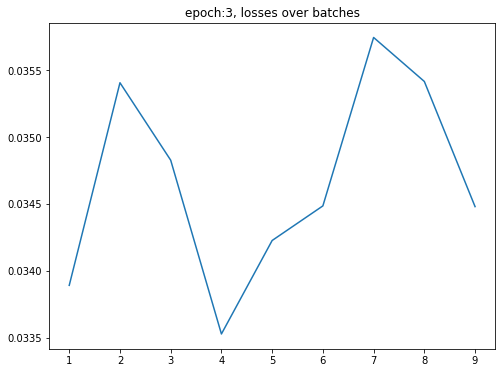

313/313 [==============================] - 1s 2ms/step - loss: 0.0777 - acc: 0.9766
------------------------------
epoch:3, val_loss:0.0777, val_acc:0.9766



In [15]:
MONITOR_STEP = 50

for epoch in range(1, 4):
    batch = 1
    total_loss = 0
    losses = []
    for x, y in get_batches(x_train, y_train, batch_size=128):
        # 배치별 훈련
        loss, acc = model.train_on_batch(x, y)
        total_loss += loss

        # 출력
        if batch % MONITOR_STEP == 0:
            losses.append(total_loss / batch)
            print(f'epoch:{epoch}, batch:{batch}, batch_loss:{loss:.4f}, batch_accuracy:{acc:.4f}, avg_loss:{total_loss/batch:.4f}')
        batch += 1

    # Loss 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, batch // MONITOR_STEP+1), losses)
    plt.title(f'epoch:{epoch}, losses over batches')
    plt.show()

    # 결과 출력
    loss, acc = model.evaluate(x_test, y_test)
    print('---'*10)
    print(f'epoch:{epoch}, val_loss:{loss:.4f}, val_acc:{acc:.4f}')
    print()

- 50개의 배치 훈련이 끝난 후 전체 손실에 대한 평균을 구한 뒤 리스트에 추가
- 하나의 epoch 훈련이 끝난 후 배치별 손실 평균을 시각화
---
- `fit()` 메소드를 사용하면 배치별 훈련 제어나 epoch마다 시각화가 어려움
- `train_on_batch()` 메소드를 사용하면 더 자세한 모니터링 가능

## 3-2 자동 미분
- 텐서플로는 그래디언트를 손쉽게 업데이트 할 수 있는 자동 미분 기능을 지원
- `GradientTape()`을 통해 계산 과정을 기록한 뒤 `gradient()` 메소드로 미분 계산 가능

In [16]:
# a, b의 Variable 생성
a = tf.Variable([1, 2, 3, 4, 5], dtype=tf.float32)
b = tf.Variable([10, 20, 30, 40, 50], dtype=tf.float32)

# 미분 계산을 위해 a, b가 미분 가능한 객체인지 확인
print(f'a.trainable:{a.trainable}\nb.trainable:{b.trainable}')

a.trainable:True
b.trainable:True


In [18]:
# c = a * b
# c를 a에 대한 편미분 -> b
# c를 b에 대한 편미분 -> a
with tf.GradientTape() as tape:
    c = a * b
grads = tape.gradient(c, [a, b])
tf.print(f'dc/da: {grads[0]}')
tf.print(f'dc/db: {grads[1]}')


dc/da: [10. 20. 30. 40. 50.]
dc/db: [1. 2. 3. 4. 5.]


- `tf.GradientTape()`의 범위를 정의하고 `tape`로 지정
- `with`문 내에서 `c = a * b` 정의
- `tape`는 계산 그래프를 저장하는데 `with`문 바깥에서 `tape.gradient()`로 미분 계산 가능
- `tape.gradient(c, [a, b])`는 c를 a, b에 대한 편미분을 각각 구해 반환
---
- 식을 계산하고 손실을 구한 뒤 자동 미분 기능을 활용해 w, b값을 업데이트하여 최종 w, b를 찾도록 계산 

In [22]:
# x, y 샘플 데이터 셋
x = tf.Variable(np.random.normal(size=(100, )), dtype=tf.float32)
y = 2 * x + 3
print(f'x[:5]: {x[:5].numpy()}\ny[:5]: {y[:5].numpy()}')

x[:5]: [-0.46737233  1.887552   -0.19445449 -1.3256446   0.53800327]
y[:5]: [2.0652554  6.775104   2.6110911  0.34871078 4.0760064 ]


- x는 100개의 난수, y = 2x + 3으로 나온 결과 저장 -> w = 2, b = 3

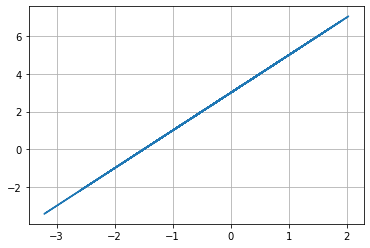

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x.numpy(), y.numpy())
ax.grid()
plt.show()

In [25]:
# 학습률, 최대 epoch 정의
learning_rate = 0.25
EPOCHS = 100

# w, b 초기값을 0.0으로 설정, float 타입
w = tf.Variable(0.0)
b = tf.Variable(0.0)

for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:
        # 예측값
        y_hat = w * x + b
        # 손실 계산(MSE)
        loss = tf.reduce_mean((y_hat - y)**2)

    # 그래디언트 계산
    dw, db = tape.gradient(loss, [w, b])

    # 그래디언트 계산
    w = tf.Variable(w - learning_rate * dw)
    b = tf.Variable(b - learning_rate * db)

    print(f'epoch: {epoch}, loss:{loss.numpy():.4f}, w:{w.numpy():.4f}, b:{b.numpy():.4f}')

    # Error가 0.0005보다 작으면 탈출
    if loss.numpy() < 0.0005:
        break

epoch: 0, loss:13.1199, w:1.1480, b:1.4213
epoch: 1, loss:3.1996, w:1.6253, b:2.1771
epoch: 2, loss:0.8064, w:1.8301, b:2.5738
epoch: 3, loss:0.2068, w:1.9209, b:2.7802
epoch: 4, loss:0.0535, w:1.9623, b:2.8870
epoch: 5, loss:0.0139, w:1.9817, b:2.9420
epoch: 6, loss:0.0036, w:1.9910, b:2.9703
epoch: 7, loss:0.0009, w:1.9955, b:2.9848
epoch: 8, loss:0.0002, w:1.9978, b:2.9922


## 3-3 자동 미분을 활용한 모델 훈련

In [26]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [27]:
# 기록을 위한 metric 정의
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')
optimizer = tf.keras.optimizers.Adam()

In [28]:
# 배치 생성 함수
def get_batches(x, y, batch_size=32):
    for i in range(int(x.shape[0] // batch_size)):
        x_batch = x[i * batch_size:(i+1) * batch_size]
        y_batch = y[i * batch_size:(i+1) * batch_size]
        yield(np.asarray(x_batch), np.asarray(y_batch))

In [29]:
@tf.function
def train_step(images, labels):
    # GradientTape 적용
    with tf.GradientTape() as tape:
        # 예측
        prediction = model(images, training=True)
        # 손실
        loss = loss_function(labels, prediction)
    # 미분값 계산
    gradients = tape.gradient(loss, model.trainable_variables)
    # optimizer 적용
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # loss, accuracy 계산
    train_loss(loss)
    train_accuracy(labels, prediction)

@tf.function
def valid_step(images, labels):
    # 예측
    prediction = model(images, training=False)
    # 손실
    loss = loss_function(labels, prediction)
    # loss, accuracy 계산
    valid_loss(loss)
    valid_accuracy(labels, prediction)

    

In [30]:
# 초기화 코드
train_loss.reset_states()
train_accuracy.reset_states()
valid_loss.reset_states()
valid_accuracy.reset_states()

# epoch 반복
for epoch in range(5):
    # batch별 순회
    for images, labels in get_batches(x_train, y_train):
        # train_step
        train_step(images, labels)
    
    for images, labels in get_batches(x_test, y_test):
        # valid_step
        valid_step(images, labels)

    # 결과 출력
    metric_template = 'epoch: {}, loss: {:.4f}, acc: {:.2f}%  val_loss: {:.4f}  val_acc: {:.2f}%'
    print(metric_template.format(epoch+1, train_loss.result(), train_accuracy.result()*100,
                                 valid_loss.result(), valid_accuracy.result()*100))

epoch: 1, loss: 0.2463, acc: 92.69%  val_loss: 0.1233  val_acc: 96.15%
epoch: 2, loss: 0.1731, acc: 94.84%  val_loss: 0.1154  val_acc: 96.45%
epoch: 3, loss: 0.1376, acc: 95.89%  val_loss: 0.1093  val_acc: 96.67%
epoch: 4, loss: 0.1152, acc: 96.54%  val_loss: 0.1111  val_acc: 96.71%
epoch: 5, loss: 0.1001, acc: 96.97%  val_loss: 0.1109  val_acc: 96.79%
